In [5]:
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, norm, shapiro
import os
from itertools import combinations
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from scipy import ndimage
import glob
import json

%matplotlib inline

In [2]:
chroms= ['chr'+str(x) for x in range(1, 23)] + ['chrX', 'chrY']
bed = []
data = {
    'nodes': [],
    'edges': [],
    'quads': [],
    'endPos': [],
    'beginPos': [],
    'strands': [],
    'chroms': [],
    'ghostBeginPos': []
}
for strand in ['positive', 'negative']:
    s = '+' if strand == 'positive' else '-'
    data_dir = './data/chrom_wise_graph_summary/%s' % strand
    for chrom in chroms:
        d = json.load(open('%s/%s.json' % (data_dir, chrom)))
        d['strands'] = [s for x in range(len(d['nodes']))]
        d['chroms'] = [chrom for x in range(len(d['nodes']))]
        for i in d:
            data[i].extend(d[i])

In [3]:
data.keys()

dict_keys(['nodes', 'edges', 'quads', 'strands', 'beginPos', 'endPos', 'chroms', 'ghostBeginPos'])

In [4]:
nodes = np.array(data['nodes'])
edges = np.array(data['edges'])
data['spans'] = np.array(data['endPos']) - np.array(data['beginPos'])
data['graph_density'] = (2*edges)/(nodes * (nodes-1))
data['node_density'] = nodes/data['spans']
data['score'] = np.array(data['node_density']) + np.array(data['graph_density'])

In [5]:
len(data['nodes']), sum(data['nodes']), sum(data['edges']), sum(data['quads']), sum(data['spans'])

(5858234, 200097266, 2010711252, 433579218942, 994118624)

In [6]:
max(data['nodes']), max(data['edges']), max(data['quads']), max(data['spans'])

(18438, 475937, 1476614909, 50853)

In [7]:
min(data['nodes']), min(data['edges']), min(data['quads']), min(data['spans'])

(4, 3, 1, 14)

In [8]:
np.mean(data['nodes']), np.mean(data['edges']), np.mean(data['quads']), np.mean(data['spans'])

(34.156584731849222,
 343.22822406889173,
 74011.932425710547,
 169.69595683613866)

In [9]:
np.median(data['nodes']), np.median(data['edges']), np.median(data['quads']), np.median(data['spans'])

(20.0, 75.0, 293.0, 123.0)

In [10]:
len(np.where(np.array(data['quads']) == 1)[0])

87200

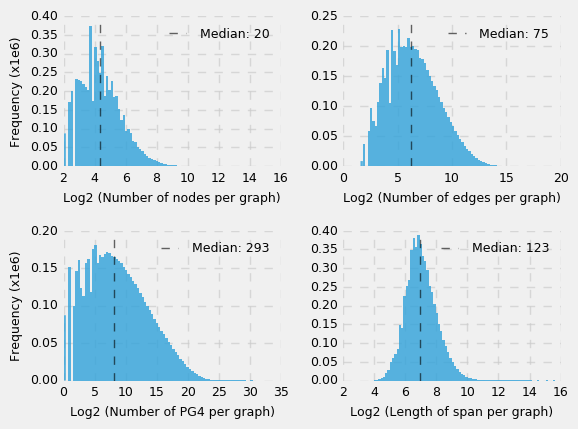

In [53]:
plt.style.use('fivethirtyeight')

from matplotlib.ticker import FuncFormatter

def millions(x, pos):
    return '%1.2f' % (x*1e-6)
formatter = FuncFormatter(millions)

keys = ['nodes', 'edges', 'quads', 'spans', 'graph_density', 'node_density']
loc = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
labels = ['Number of nodes per graph', 'Number of edges per graph', 'Number of PG4 per graph',
          'Length of span per graph', 'Density of each graph', 'Node density per graph']
#fig, axis = plt.subplots(3, 2, figsize=(6,5))
#for i in range(6):
fig, axis = plt.subplots(2, 2, figsize=(6,4.5))
for i in range(4):
    ax = axis[loc[i]]
    ax.hist(np.log2(data[keys[i]]), bins=80, edgecolor='none',
            alpha=0.8)
    median = np.median(data[keys[i]])
    ax.axvline(np.log2(median), lw=1, ls='--', color='k',
               alpha=0.6, label="Median: %d" % median)
    if loc[i][1] == 0:
        ax.set_ylabel('Frequency (x1e6)', fontsize=9)
    ax.set_xlabel('Log2 (%s)' % labels[i], fontsize=9)
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    ax.grid(which='major', linestyle='--', alpha=0.7)
    ax.yaxis.set_major_formatter(formatter)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.legend(loc='best', frameon=False, fontsize=9)

fig.tight_layout()
plt.savefig('properties_distribution.pdf', transparent=True, edgecolor='none')
plt.savefig('properties_distribution.png', dpi=300, transparent=True, edgecolor='none')
plt.show()

In [28]:
rvals = defaultdict(dict)
keys = ['nodes', 'edges', 'quads', 'spans', 'graph_density', 'node_density']
for i in combinations(keys, r=2):
    rvals[i[0]][i[1]] = pearsonr(data[i[0]], data[i[1]])[0]
df = pd.DataFrame(rvals).reindex(keys).reindex_axis(keys, axis=1)
for i in df:
    for j in keys:
        df[j][i] = df[i][j]
df

,nodes,edges,quads,spans,graph_density,node_density
nodes,NaN,0.913340,0.442394,0.862069,-0.419221,0.331613
edges,0.913340,NaN,0.691379,0.664405,-0.250547,0.323343
quads,0.442394,0.691379,NaN,0.243230,-0.072381,0.109046
spans,0.862069,0.664405,0.243230,NaN,-0.603182,0.020505
graph_density,-0.419221,-0.250547,-0.072381,-0.603182,NaN,0.068453
node_density,0.331613,0.323343,0.109046,0.020505,0.068453,NaN


/home/parashar/anaconda3/lib/python3.5/site-packages/scipy/stats/morestats.py:1330: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


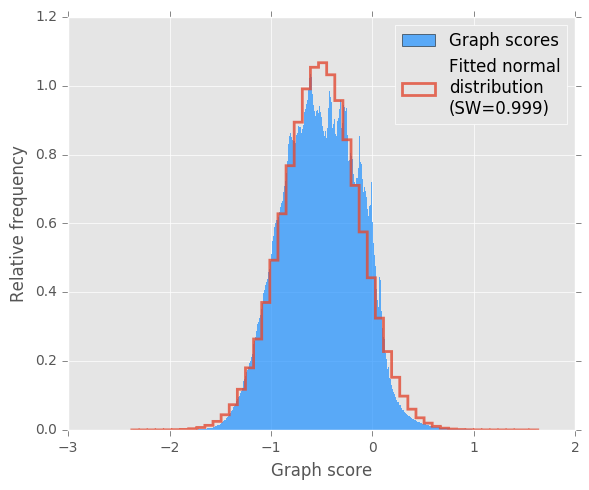

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

shapiro_w = "%.3f" % shapiro(np.log(data['score']))[0]
loc = np.mean(np.log(data['score']))
scale = np.std(np.log(data['score']))
norm = np.random.normal(loc, scale, len(data['score']))
_ = ax.hist(np.log(data['score']), bins=500, color='dodgerblue',
            edgecolor='none', alpha=0.7, normed=True, label='Graph scores')
_ = ax.hist(norm, bins=50, alpha=0.8, normed=True, histtype='step',
            lw=2, label='Fitted normal\ndistribution\n(SW=%s)' % shapiro_w)
ax.legend()
ax.set_xlabel('Graph score')
ax.set_ylabel('Relative frequency')

fig.tight_layout()
plt.savefig('graph_score_dist.png', dpi=200)
plt.show()

In [30]:
min(data['score']), max(data['score'])

(0.060119181110434752, 5.288694638694639)

In [31]:
out_handles = {chrom: open('./data/QuadGraphs_bed/%s.bed' % chrom, 'w')
               for chrom in chroms}

for i in tqdm(range(len(data['nodes']))):
    bed_line = [data['chroms'][i], data['beginPos'][i], data['endPos'][i] + 1,
                data['ghostBeginPos'][i], data['score'][i], data['strands'][i]]
    out_handles[data['chroms'][i]].write("\t".join(map(str, bed_line)) + '\n')
    
for i in out_handles:
    out_handles[i].close()

100%|██████████| 5858234/5858234 [00:56<00:00, 102930.66it/s]


In [ ]:
!cat QuadGraphs_bed/* | sort -k 1,1 -k2n,2 > QuadGraph.bed

In [100]:
loop_dir = "./data/quad_graph_loop_profile"
chroms = ['chr%d' % i for i in range(1, 23)] + ['chrX', 'chrY']
strands = ["positive", 'negative']
keys = [
        "0_0", "0_1", "0_2", "0_3",
        "1_0", "1_1", "1_2", "1_3",
        "2_0", "2_1", "2_2", "2_3",
        "3_0", "3_1", "3_2", "3_3",
    ]
loop_data = {str(x): [] for x in range(1, 51)}
bulge_data = {'0': [], '1': [], '2': [], '3': []}
for chrom in chroms:
    fns = sorted(glob.glob("%s/%s/*/*.json" % (loop_dir, chrom)))
    for fn in tqdm(fns, desc=chrom):
        d = json.load(open(fn))
        temp = {str(x): 0 for x in range(1, 51)}
        for k in d[0]:
            for l in d[0][k]:
                temp[l]+=d[0][k][l]
        for l in temp:
            loop_data[l].append(temp[l])
        for k in d[1]:
            bulge_data[k].append(d[1][k])

chrY: 100%|██████████| 120/120 [00:01<00:00, 85.19it/s]


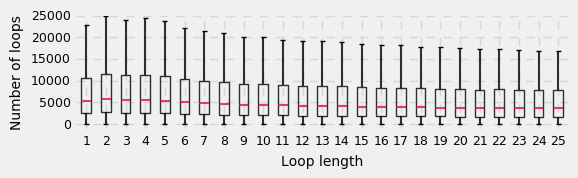

In [107]:
plt.style.use('fivethirtyeight')

boxprops = dict(linestyle='-', linewidth=1, color='k', alpha=0.8)
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson', alpha=0.8)
whiskerprops = dict(linestyle='-', linewidth=1.5, color='k', alpha=0.8)

for_box = []
for i in range(1, 26):
    for_box.append(np.array(loop_data[str(i)]))
fig, ax = plt.subplots(1, 1, figsize=(6,2))
ax.boxplot(for_box, sym='', boxprops=boxprops,
           medianprops=medianprops, whiskerprops=whiskerprops)
ax.xaxis.set_tick_params(labelsize=9)
ax.yaxis.set_tick_params(labelsize=9)
ax.grid(which='major', linestyle='--', alpha=0.7)
for i in ['top', 'bottom', 'left', 'right']:
    ax.spines[i].set_visible(False)
ax.set_xlabel('Loop length', fontsize=10)
ax.set_ylabel('Number of loops', fontsize=10)
ax.set_yticks([x for x in range(0, 30000, 5000)])
ax.set_ylim((-1000, 25001))
plt.tight_layout()
plt.savefig('quadgraph_loop_dists.pdf', transparent=True, edgecolor='none')
plt.savefig('quadgraph_loop_dists.png', dpi=300, transparent=True, edgecolor='none')
plt.show()

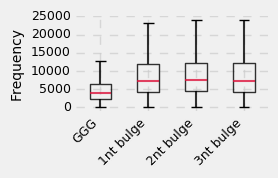

In [124]:
plt.style.use('fivethirtyeight')

boxprops = dict(linestyle='-', linewidth=1, color='k', alpha=0.8)
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson', alpha=0.8)
whiskerprops = dict(linestyle='-', linewidth=1.5, color='k', alpha=0.8)

for_box = []
for i in range(0, 4):
    for_box.append(np.array(bulge_data[str(i)]))

fig, ax = plt.subplots(1, 1, figsize=(3,2))
ax.boxplot(for_box, sym='', boxprops=boxprops,
           medianprops=medianprops, whiskerprops=whiskerprops)
ax.xaxis.set_tick_params(labelsize=9)
ax.yaxis.set_tick_params(labelsize=9)
ax.grid(which='major', linestyle='--', alpha=0.7)
for i in ['top', 'bottom', 'left', 'right']:
    ax.spines[i].set_visible(False)
ax.set_ylabel('Frequency', fontsize=10)
ax.set_yticks([x for x in range(0, 30000, 5000)])
ax.set_ylim((-1000, 25001))
ax.set_xticklabels(['GGG', '1nt bulge', '2nt bulge', '3nt bulge'],
                      rotation=45, ha='right', va='top')
plt.tight_layout()
plt.savefig('quadgraph_bulges.pdf', transparent=True, edgecolor='none')
plt.savefig('quadgraph_bulges.png', dpi=300, transparent=True, edgecolor='none')
plt.show()